# Estimating lost life year due to Corona in runaway scenario

In [4]:
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
from pandas_utils import extract_interval_end_from_text, text_interval_index_to_interval_index, reduce_histogram_resolution
import parameters

import matplotlib
matplotlib.rcParams['figure.figsize'] = [18, 6]
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'

In [5]:
path_data = Path("../data")
path_results = Path("../analysis_results")
pprint(list(path_data.iterdir()))

[PosixPath('../data/israel_2019_age_pyramid.csv'),
 PosixPath('../data/mortality_per_1000_people_femails_by_age_year.csv'),
 PosixPath('../data/mortality_2017_by_age.csv'),
 PosixPath('../data/manipulated_copy_of_mortality_2017_by_age.ods'),
 PosixPath('../data/mortality_per_1000_people_2017_by_age.csv'),
 PosixPath('../data/health_office_models_runaway_stats.csv'),
 PosixPath('../data/WHO_residual_life_expectancy_by_year_group_age.csv'),
 PosixPath('../data/mortality_per_1000_people_mails_by_age_year.csv'),
 PosixPath('../data/residual_life_expectancy_femails_age_year.csv'),
 PosixPath('../data/WHO_residual_life_expectancy_2016_by_group_age.csv'),
 PosixPath('../data/israel_health_expenditure_each_year.csv'),
 PosixPath('../data/.~lock.health_office_models_runaway_stats.csv#'),
 PosixPath('../data/united_kingdom'),
 PosixPath('../data/israel_health_spending_inflation_adjusted.csv'),
 PosixPath('../data/health_office_models_runaway_distribution_of_death.csv'),
 PosixPath('../data/resid

## understanding orders of magnitude: how many die in a normal year?

year 2017

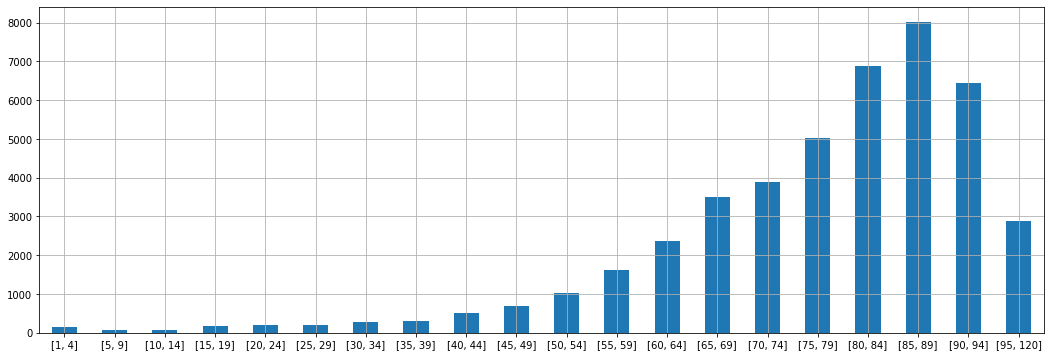

In [6]:
normal_mortality_by_age = pd.read_csv(path_data.joinpath('mortality_2017_by_age.csv'), skiprows=[1,2,], index_col=0)
normal_mortality_by_age.index = text_interval_index_to_interval_index(normal_mortality_by_age.index, closed='both')
normal_mortality_by_age['both_sexes'] = normal_mortality_by_age.mails + normal_mortality_by_age.femails
normal_mortality_by_age.both_sexes.plot.bar(rot=0)

## estimate corona death by health office (see data)

In [7]:
print(parameters.MOH_scenario)


4


In [8]:
print(parameters.corona_mortality_tot[parameters.MOH_scenario])
corona_mortality_tot = parameters.corona_mortality_tot[parameters.MOH_scenario]
#corona_mortality_tot = 8600 #best case

21600


In [9]:
DF_death = pd.read_csv(path_data.joinpath('health_office_models_runaway_distribution_of_death.csv'), index_col=0)

In [10]:
DF_death.loc['80-120', 'fraction_of_total_corona_mortality'] = 1 - DF_death.fraction_of_total_corona_mortality.sum()

In [11]:
DF_death

fraction_of_total_corona_mortality
age_group                                    
0-9                                     0.000
10-19                                   0.001
20-29                                   0.007
30-39                                   0.015
40-49                                   0.028
50-59                                   0.079
60-69                                   0.241
70-79                                   0.303
80-120                                  0.326

In [12]:
DF_death.index =text_interval_index_to_interval_index(DF_death.index, closed='both')

DF_death['COVID_19_mortality'] = DF_death.fraction_of_total_corona_mortality * corona_mortality_tot

DF_death['normal_mortality'] = reduce_histogram_resolution(normal_mortality_by_age.both_sexes, DF_death.index)

age_pyramid = pd.read_csv(path_data.joinpath('israel_2019_age_pyramid.csv'), index_col=0)
age_pyramid.index = text_interval_index_to_interval_index(age_pyramid.index, closed='both')
DF_death['population'] = reduce_histogram_resolution(age_pyramid.M + age_pyramid.F, DF_death.index)

DF_death

fraction_of_total_corona_mortality  COVID_19_mortality  \
[0, 9]                                  0.000                 0.0   
[10, 19]                                0.001                21.6   
[20, 29]                                0.007               151.2   
[30, 39]                                0.015               324.0   
[40, 49]                                0.028               604.8   
[50, 59]                                0.079              1706.4   
[60, 69]                                0.241              5205.6   
[70, 79]                                0.303              6544.8   
[80, 120]                               0.326              7041.6   

           normal_mortality  population  
[0, 9]                219.0   1654530.0  
[10, 19]              246.0   1377821.0  
[20, 29]              420.0   1178880.0  
[30, 39]              604.0   1117905.0  
[40, 49]             1211.0   1019070.0  
[50, 59]             2643.0    779142.0  
[60, 69]             5892.0    702437.0  
[70, 79]             8896.0    430872.0  
[80, 120]           24220.0    258715.0

## estimates of net corona mortality
Due to overlap: how many people that would have died anyway for normal reasons, would die of corona instead?


In [13]:
print(f'corona_normal_death_overlap_model: {parameters.corona_normal_death_overlap_model}')

corona_normal_death_overlap_model: independent


In [14]:
if parameters.corona_normal_death_overlap_model == 'independent':
    DF_death['net_COVID_19_mortality'] = DF_death.COVID_19_mortality * (1 - DF_death.normal_mortality / DF_death.population)
elif parameters.corona_normal_death_overlap_model == 'full_correlation':
    raise(NotImplementedError('check before use'))
    (DF_death.corona_mortality - DF_death.normal_mortality).clip(0)
elif parameters.corona_normal_death_overlap_model == 'estimate_1':
    p_corona_death_given_normal_death = 0.25 # not arbitrary, to be explained: 2017 death stats: 80% of death from underlying desease / risk factor
    # also severe scenario: 80% of population are sick. let's make a hardening assumption: ortigonality
    # from the group of those who had background desease severe enough to make them die, and also got corona, how many would be finished by the corona?
    # at least a third
    DF_death['net_corona_mortality'] = (DF_death.corona_mortality - DF_death.normal_mortality * p_corona_death_given_normal_death).clip(0)


In [15]:
DF_death

fraction_of_total_corona_mortality  COVID_19_mortality  \
[0, 9]                                  0.000                 0.0   
[10, 19]                                0.001                21.6   
[20, 29]                                0.007               151.2   
[30, 39]                                0.015               324.0   
[40, 49]                                0.028               604.8   
[50, 59]                                0.079              1706.4   
[60, 69]                                0.241              5205.6   
[70, 79]                                0.303              6544.8   
[80, 120]                               0.326              7041.6   

           normal_mortality  population  net_COVID_19_mortality  
[0, 9]                219.0   1654530.0                0.000000  
[10, 19]              246.0   1377821.0               21.596143  
[20, 29]              420.0   1178880.0              151.146132  
[30, 39]              604.0   1117905.0              323.824944  
[40, 49]             1211.0   1019070.0              604.081293  
[50, 59]             2643.0    779142.0             1700.611562  
[60, 69]             5892.0    702437.0             5161.935735  
[70, 79]             8896.0    430872.0             6409.672768  
[80, 120]           24220.0    258715.0             6382.389858

## using residual life expectancy to translate death to lost life years

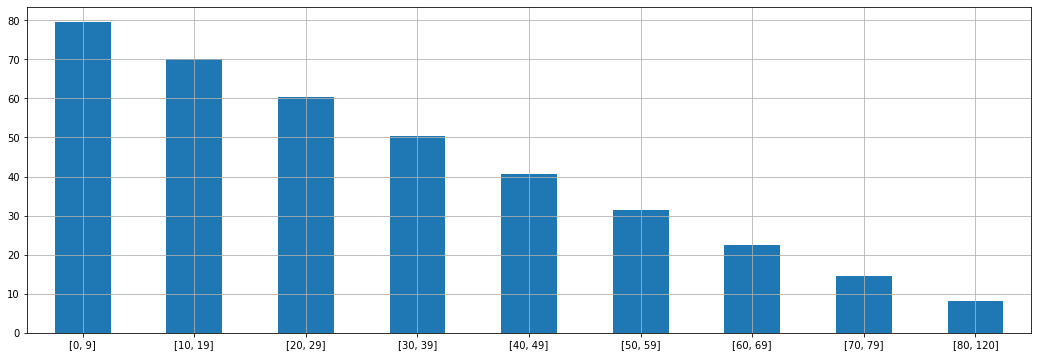

In [16]:
residual_life_expectancy = pd.read_csv(path_data.joinpath('WHO_residual_life_expectancy_2016_by_group_age.csv'), index_col=0, skiprows=[1,])
residual_life_expectancy.index = text_interval_index_to_interval_index(residual_life_expectancy.index, closed='both')
DF_death['residual_life_expectancy'] = reduce_histogram_resolution(residual_life_expectancy.mean(axis=1), DF_death.index) / 2
DF_death.residual_life_expectancy.plot.bar(rot=0)

In [17]:
DF_death['COVID_19_lost_life_years'] = DF_death.residual_life_expectancy * DF_death.net_COVID_19_mortality
DF_death['normally_lost_life_years'] = DF_death.residual_life_expectancy * DF_death.normal_mortality
DF_death['COVID_19_to_normally_lost_life_years'] = DF_death.COVID_19_lost_life_years / DF_death.normally_lost_life_years

In [18]:
DF_death.loc[:, ['COVID_19_lost_life_years', 'normally_lost_life_years']]

COVID_19_lost_life_years  normally_lost_life_years
[0, 9]                     0.000000                 17410.500
[10, 19]                1513.349754                 17238.450
[20, 29]                9102.775795                 25294.500
[30, 39]               16336.968424                 30471.800
[40, 49]               24601.210655                 49317.975
[50, 59]               53314.172467                 82858.050
[60, 69]              116143.554041                132570.000
[70, 79]               92459.529675                128324.800
[80, 120]              52016.477339                197393.000

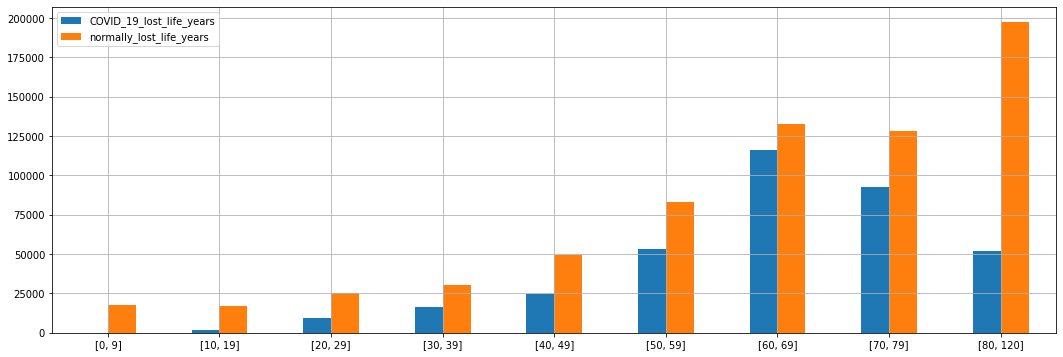

In [19]:
DF_death.loc[:, ['COVID_19_lost_life_years', 'normally_lost_life_years']].plot.bar(rot=0)

## total corona lost life years

In [20]:
DF_death.COVID_19_lost_life_years.sum()

365488.03815064364

## final table

In [21]:
DF_death.to_csv(path_results.joinpath('df_death.csv'))

In [22]:
pprint(DF_death)

           fraction_of_total_corona_mortality  COVID_19_mortality  \
[0, 9]                                  0.000                 0.0   
[10, 19]                                0.001                21.6   
[20, 29]                                0.007               151.2   
[30, 39]                                0.015               324.0   
[40, 49]                                0.028               604.8   
[50, 59]                                0.079              1706.4   
[60, 69]                                0.241              5205.6   
[70, 79]                                0.303              6544.8   
[80, 120]                               0.326              7041.6   

           normal_mortality  population  net_COVID_19_mortality  \
[0, 9]                219.0   1654530.0                0.000000   
[10, 19]              246.0   1377821.0               21.596143   
[20, 29]              420.0   1178880.0              151.146132   
[30, 39]              604.0   1117905.0  